### Plot IDM results using the DataFrame stored in IDMResults.pcl 

In [15]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os
from pandas.io.json import json_normalize
import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import griddata

pd.options.mode.chained_assignment = None #Disable copy warnings
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options

#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

In [16]:
def getSmoothCurve(x,y,z,stepX=20.,stepY=0.5,doLog=True,doMax=True):

    if doLog:
        yv = np.log10(y[y > 0.]).tolist()
        xv = x[y > 0.].tolist()
        zv = z[y > 0.].tolist()
    else:
        yv = y.tolist()
        xv = x.tolist()    
        zv = z.tolist()
    
    points = list(zip(xv,yv))
    xbins = np.arange(min(xv),max(xv),stepX)
    ybins = np.arange(min(yv),max(yv),stepY)
    zvals = np.array([[0.]*len(ybins)]*len(xbins))
    for ipt,pt in enumerate(points):
        if not (xbins.min() < pt[0] < xbins.max()):
            continue
        if not (ybins.min() < pt[1] < ybins.max()):
            continue
        ix = np.searchsorted(xbins,pt[0])-1
        iy = np.searchsorted(ybins,pt[1])
        if doMax:
            zvals[ix,iy] = max(zvals[ix,iy],zv[ipt])
        else:
            if zvals[ix,iy] == 0.:
                zvals[ix,iy] = zv[ipt]
            else:
                zvals[ix,iy] += zv[ipt]
                zvals[ix,iy] = zvals[ix,iy]/2.            

        
    xpoints = []
    ypoints = []
    zpoints = []
    for ix,xval in enumerate(xbins):
        for iy,yval in enumerate(ybins):
            xpoints.append(xval)
            ypoints.append(yval)
            zpoints.append(zvals[ix,iy])
    cs = plt.tricontour(xpoints,ypoints,zpoints,levels=[1.],linewidths=0)
    curve = None
    for c in cs.collections[0].get_paths():
        if curve is None:
            curve = c.vertices
        elif len(c.vertices) > len(curve):
            curve = c.vertices
    plt.cla()
    if doLog:
        curve[:,1] = np.power(10,curve[:,1])
    return curve

In [17]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('IDMResults.pcl')
#print(dataDF.columns.values.tolist()) #Print all columns names

In [18]:
#Set points without results with r == 0
dataDF.fillna(value={'ExptRes.result0.r' : 0.0},inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)
#Add simple flag for excluded points:
dataDF['excluded'] = dataDF['ExptRes.result0.r'] > 1.
#Replace zero widths by small value:
# dataDF = dataDF[dataDF['width.37'] > 0.]
dataDF['width.37'] = dataDF['width.37'].map(lambda x: x if x > 0. else 1e-50)

1.6109421790947471


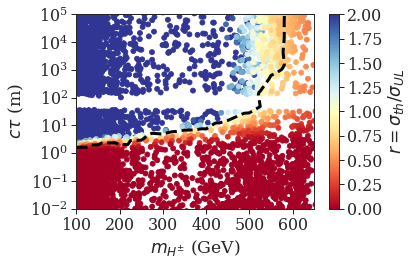

In [19]:
mHc = dataDF['mass.37']
ctau = 1.967e-16/dataDF['width.37']
r = dataDF['ExptRes.result0.r']
x,y,z = mHc,ctau,r
# # Plot scatter plot (for double checking the results)
# cs = plt.tricontour(x,np.log10(y),z,levels=[1.],linewidths=0)
plt.figure()
curve = getSmoothCurve(x,y,z,stepX=25.,stepY=0.5,doLog=True,doMax=True)
cp = plt.scatter(x,y, c=z, vmin=0., vmax=2., s=25, cmap=cm)
plt.plot(curve[:,0],curve[:,1],color='black',linewidth=3,linestyle='--')
cb = plt.colorbar(cp)
plt.yscale('log')
plt.xlabel(r'$m_{H^{\pm}}$ (GeV)')    
plt.ylabel(r'$c\tau$ (m)')
cb.set_label(r'$r=\sigma_{th}/\sigma_{UL}$')
plt.ylim(1e-2,1e5)
plt.yticks(np.power(10.,np.arange(-2., 6., 1.)))
plt.xlim(100,650)
plt.xticks(np.arange(100.,700.,100.))
plt.tight_layout()
plt.savefig('IDM_points_r.png',dpi=500)
print(curve[:,1].min())
plt.show()

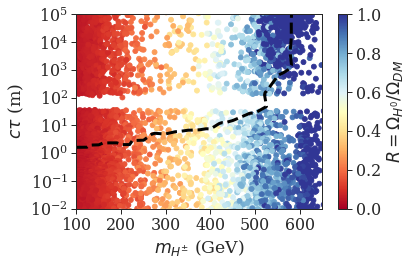

In [ ]:
relicRatio = dataDF['rat']
x,y,z = mHc,ctau,relicRatio
plt.figure()
cp = plt.scatter(x,y, c=z, vmin=0., vmax=1., s=25, cmap=cm)
plt.plot(curve[:,0],curve[:,1],c='black',linewidth=3,linestyle='--')
cb = plt.colorbar(cp)
plt.yscale('log')
plt.xlabel(r'$m_{H^{\pm}}$ (GeV)') 
plt.ylabel(r'$c\tau$ (m)')
cb.set_label(r'$R= \Omega_{H^0}/\Omega_{DM}$')
plt.ylim(1e-2,1e5)
plt.yticks(np.power(10.,np.arange(-2., 6., 1.)))
plt.xlim(100,650)
plt.xticks(np.arange(100.,700.,100.))
plt.tight_layout()
plt.savefig('IDM_relicRatio.png',dpi=500)
plt.show()

In [ ]:
deltaM = (dataDF['mass.37']-dataDF['mass.35'])
mHc = dataDF['mass.37']
r = dataDF['ExptRes.result0.r']
cm = plt.cm.get_cmap('RdYlBu')
x,y,z = mHc,deltaM,r
plt.figure()
curveDM = getSmoothCurve(x,y,z,stepX=20.,stepY=0.07,doLog=True,doMax=False)
cp = plt.scatter(x,y, c=z, vmin=0., vmax=2., s=25, cmap=cm)
plt.plot(curveDM[:,0],curveDM[:,1],c='black',linewidth=3,linestyle='--')
cb = plt.colorbar(cp)
plt.yscale('log')
plt.xlabel(r'$m_{H^{\pm}}$ (GeV)') 
plt.ylabel(r'$m_{H^{\pm}} - m_{H^{0}}$ (GeV)')
cb.set_label(r'$r=\sigma_{th}/\sigma_{UL}$')
plt.ylim(3e-2,1.0)
plt.xlim(100,650)
plt.xticks(np.arange(100.,700.,100.))
plt.tight_layout()
plt.savefig('IDM_points_deltaM.png',dpi=500)
plt.show()

In [ ]:
relicRatio = dataDF['rat']
mDM = dataDF['mass.35']
x,y,z = mDM,deltaM,relicRatio
plt.figure()
cp = plt.scatter(x,y, c=z, vmin=0., vmax=1., s=25, cmap=cm)
plt.plot(curveDM[:,0],curveDM[:,1],c='black',linewidth=3,linestyle='--')
cb = plt.colorbar(cp)
plt.yscale('log')
plt.xlabel(r'$m_{H^0}$ (GeV)')    
plt.ylabel(r'$m_{H^{\pm}} - m_{H^{0}}$ (GeV)')
cb.set_label(r'$R= \Omega_{IDM}/\Omega_{CDM}$')
plt.ylim(3e-2,1.0)
plt.xlim(100,650)
plt.xticks(np.arange(100.,700.,100.))
plt.tight_layout()
plt.savefig('IDM_relicRatio_deltaM.png',dpi=500)
plt.show()

In [9]:
def getShortTxname(txList):
    if not isinstance(txList,list):
        return 'None'
    if len(txList) < 1:
        return 'None'
    elif len(txList) == 1:
        return txList[0]
    elif 'HSCP' in txList[0]:        
        return 'MultiHSCP'    
    else:        
        return ", ".join(txList)
#Add short Txname notation:
dataDF['txshort'] = dataDF['ExptRes.result0.TxNames'].map(getShortTxname)

In [10]:
#Create dictionary with txname dataframes
excludedDF =
groupedDF = OrderedDict([[tx,excludedDF[excludedDF['txshort'] == tx]] 
                         for tx in sorted(excludedDF['txshort'].unique())])

#Define topology dictionary
txDict = {'MultiHSCP' : 'HSCP SMS', 
          'THSCPM1b' : r'$p p \to X_{HSCP} + X_{HSCP}$',
         'THSCPM3' : r'$p p \to Y + Y,\; Y \to X_{HSCP} + SM$',
         'THSCPM5' : r'$p p \to Z + Z,\; Z \to Y + SM,\; Y \to X_{HSCP} + SM$',
         'THSCPM7' : r'$p p \to Z_1 + Z_2,\; Z_1 \to X_{HSCP} + SM,\; Z_2 \to Y + SM,\; Y \to X_{HSCP} + SM$',
         'THSCPM8' : r'$p p \to Y + Y,\; Y \to X_{HSCP} + SM + SM$',
         'TRHadGM1' : r'$R_{hadron}(\tilde{g})$ pair prod.',
         'TRHadQM1' : r'$R_{hadron}(\tilde{q})$ pair prod.',
         'Allowed' : 'Non-Excluded'
         }
#Check for undefined topologies:
for tx in groupedDF:
    if not tx in txDict:
        print(tx,'missing')

SyntaxError: invalid syntax (<ipython-input-10-0293c2062260>, line 2)